In [1]:
%run /home/user/besos/Matthias/tools/imports.ipynb
from tensorflow.keras import regularizers
def preprocess(X, y, standardization=None):
    
    if standardization is None:
        standardization = [StandardScaler() for i in range(2)]
        X = standardization[0].fit_transform(X)
        y = standardization[1].fit_transform(y)
    else:
        X = standardization[0].transform(X)
        y = standardization[1].transform(y)

    return X, y, standardization

def get_model_1(n_params=13, n_neurons=256, alpha=0.03):
    inputs = Input(shape=(n_params))
    hidden = Dense(n_neurons, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha))(inputs)
    outputs = Dense(1, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha))(hidden)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='mse')
    model.summary()
    
    return model

ann = KerasRegressor(build_fn=get_model_1, epochs=800)

In [2]:
X, y = read_samples('CAN', param_set=23, limit=10000, output_meter = 'DistrictHeating:Facility')
X_train, X_test, y_train,  y_test = train_test_split(X.iloc[:,:13], y, test_size=0.2, shuffle=True)
X_train, y_train, standardization = preprocess(X_train, y_train)
X_test, y_test, _ = preprocess(X_test, y_test, standardization)
estimator = copy.deepcopy(ann)

early_stopping = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)
history = estimator.fit(X_train, y_train, validation_split=0.2, callbacks=[early_stopping])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               3584      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________
Train on 6385 samples, validate on 1597 samples
Epoch 1/800
6385/6385 [==============================] - 1s 192us/sample - loss: 1.1323 - val_loss: 0.9813
Epoch 2/800
6385/6385 [==============================] - 0s 53us/sample - loss: 0.8214 - val_loss: 0.8685
Epoch 3/800
6385/6385 [==============================] - 0s 53us/sample - loss: 0.7621 - val_loss: 0.8383
Epoch 4/800
6385/6385 

Winnipeg        R2 score:    37.58 %, MAPE:  20.80 %, RMSPE: 22.34 %, AE95:  32.26 %.
Ottawa          R2 score:    87.73 %, MAPE:  11.54 %, RMSPE: 18.56 %, AE95:  37.73 %.
Longueuil       R2 score:    81.53 %, MAPE:  15.26 %, RMSPE: 24.69 %, AE95:  52.39 %.
Toronto         R2 score:    15.01 %, MAPE:  34.46 %, RMSPE: 43.63 %, AE95:  82.61 %.
Taloyoak        R2 score:  -601.49 %, MAPE:  67.09 %, RMSPE: 67.17 %, AE95:  71.38 %.
Lesage          R2 score:    90.16 %, MAPE:  10.30 %, RMSPE: 18.79 %, AE95:  31.50 %.
Montreal        R2 score:    90.02 %, MAPE:  10.29 %, RMSPE: 15.88 %, AE95:  33.01 %.
Norman_Wells    R2 score:  -251.56 %, MAPE:  49.92 %, RMSPE: 50.20 %, AE95:  56.69 %.
Edmonton        R2 score:    84.11 %, MAPE:  12.12 %, RMSPE: 18.64 %, AE95:  25.36 %.
Victoria        R2 score: -4161.50 %, MAPE: 300.05 %, RMSPE: 322.74 %, AE95: 530.71 %.
Hamilton        R2 score:   -93.70 %, MAPE:  55.09 %, RMSPE: 63.98 %, AE95: 114.28 %.
Halifax         R2 score:  -353.71 %, MAPE:  84.82 %,

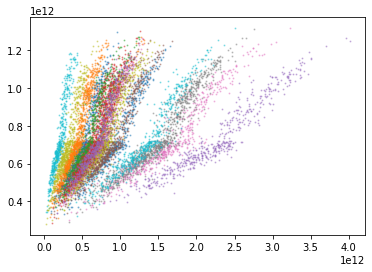

In [11]:
%run /home/user/besos/Matthias/tools/imports.ipynb
y_test_list = []
y_pred_list = []
scores = np.ndarray((20,4))
for i, city in enumerate(CAN_cities.keys()):
    X_test, y_test = read_samples(region=city, param_set=23, output_meter = 'DistrictHeating:Facility')
    X_test, y_test, _ = preprocess(X_test.iloc[:,:13], y_test, standardization)
    y_pred_test = estimator.predict(X_test)
    y_true = standardization[1].inverse_transform(y_test.reshape(len(X_test)))
    y_pred = standardization[1].inverse_transform(y_pred_test.reshape(len(X_test)))
    scores[i, 0] = r2_score(y_true, y_pred) * 100
    scores[i, 1] = MAPE(y_true, y_pred)
    scores[i, 2] = RMSPE(y_true, y_pred)
    scores[i, 3] = np.percentile(abs(y_true.ravel()-y_pred)/y_true.ravel(), 95)*100
    plt.scatter(y_true, y_pred, s=1, alpha=0.4)
    y_test_list.append(y_true.ravel())
    y_pred_list.append(y_pred)
    print(f'{city:15s} R2 score: {scores[i, 0]:8.2f} %, MAPE: {scores[i, 1]:6.2f} %, RMSPE: {scores[i, 2]:5.2f} %, AE95: {scores[i, 3]:6.2f} %.')

print(f'{"Mean":15s} R2 score: {np.mean(scores[:,0]):8.2f} %, MAPE: {np.mean(scores[:,1]):6.2f} %, RMSPE: {np.max(scores[:,2]):5.2f} %.')

In [4]:
np.save('model1_scores_test_loc', scores)

In [18]:
y_test = np.concatenate(y_test_list).ravel()
y_pred = np.concatenate(y_pred_list).ravel()
print(r2_score(y_test, y_pred) * 100)
print(MAPE(y_test, y_pred))
print(RMSPE(y_test, y_pred))
print(np.percentile(abs(y_test-y_pred)/y_test, 95)*100)

13.719652522288905
54.31269284357345
92.55210281450893
206.28972620555334
